* Calculate the eddy force function from the data,
* save training data to ../data/training/00/

In [1]:
# JM: 22 May 2021
# scrap notebook to test turning qgm2 data into eddy force function data through FEniCS

from dolfin import *
from qgm2_parameters import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import interpolate

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r"
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 12.0

ntau=80
data_dir = "../data/outputs/" # data from QG3 model

finished loading qgm2_parameters


In [2]:
# set up mesh
import matplotlib.tri as tri

mesh = RectangleMesh(Point(0.0, 0.0), Point(L, L), ngrid, ngrid)
space = FunctionSpace(mesh, "CG", 1)
test, trial = TestFunction(space), TrialFunction(space)
zero_bcs = DirichletBC(space, 0.0, "on_boundary")

# some general reusable variables
x_vec, y_vec = np.meshgrid(np.linspace(0, L, ngrid+1), np.linspace(0, L, ngrid+1))
input_points = np.array([x_vec[:].flatten(), y_vec[:].flatten()]).T
output_points = mesh.coordinates()
triang = tri.Triangulation(output_points[:, 0], output_points[:, 1])

# for putting stuff onto mesh
dof_2_vert = dof_to_vertex_map(space)

# for moving stuff onto grid
vert_2_dof = vertex_to_dof_map(space)

In [3]:
# interpolate a function onto the mesh
# FORNOW: do this with eddy PV flux to test eddy force function

# load (non-dimensional) binary data
#   if "*_int.dat", remember to divide by the (non-dim) stime to turn into t_avg data

#TODO: consider defining a class and imbuing this as a subroutine

def load_grid_data(data_dir, filename, layers=layers, tave=False):
    """tidy-up subroutine to load the grid data"""
    grid_data = np.fromfile(data_dir + filename, dtype=np.float64).reshape(layers, ngrid+1, ngrid+1)
    if tave:
        grid_data /= stime
    
    return grid_data

def grid_to_mesh(grid_data, mesh_func):
    """Takes grid data and interpolates it onto a pre-defined finite element mesh"""
    for layer in range(len(mesh_func)):
        data_in = grid_data[layer,:,:]

        # interpolator = interpolate.LinearNDInterpolator(input_points, data_in[:].flatten())
        interpolator = interpolate.NearestNDInterpolator(input_points, data_in[:].flatten())  # much faster
        mesh_func[layer].vector()[:] = interpolator(output_points[dof_2_vert])
        
    return mesh_func

def mesh_to_grid(mesh_func, ny=ngrid+1, nx=ngrid+1):
    """Takes finite element function and pull out data onto regular grid
    
       This subtroutine exploits the fact that the mesh is structued and regular, so just do it
       with vertex_to_dof map. If not regular mesh, will need to write a probing routine,
       or cheat by pulling out vertices then constructing an interpolator.
    """
    layers = len(mesh_func)
    grid_data = np.zeros((layers, ny, nx))
    for l in range(layers):
        grid_data[l, :, :] = np.reshape(mesh_func[l].vector()[vert_2_dof], (ngrid+1, ngrid+1))
        
    return grid_data

In [4]:
# a slower version of James' flux calculator class without using caching from timestepping module

import ufl

class FluxCalculator(object):
    def __init__(self, space, H, s):
        
        """ Imbue object with attributes"""
        
        self.__space  = space
        self.__H      = H
        self.__s      = s
        self.__layers = len(H)
        
        layers = len(H) # local variable for looping
        
        # Stratification
        smat = np.zeros((layers, layers))
        if layers > 1:
            smat[0, 0]   = -float(s[0][1])
            smat[0, 1]   = +float(s[0][1])
            smat[-1, -2] = +float(s[-1][0])
            smat[-1, -1] = -float(s[-1][0])
            for i in range(1, layers - 1):
                smat[i, i - 1] = +float(s[i][0])
                smat[i, i]     = -(float(s[i][0]) + float(s[i][1]))
                smat[i, i + 1] = +float(s[i][1])
        ss, modes_to_z = np.linalg.eig(smat)
        z_to_modes = np.linalg.inv(modes_to_z)
        blayer = 0;  mss = abs(ss[0])
        for i in range(1, len(ss)):
            if abs(ss[i]) < mss:
                blayer = i
                mss = abs(ss[i])
        assert(mss < 1.0e-12)
        ss = [Constant(ss[i]) for i in range(layers)]
        
        self.__ss = ss
        self.__z_to_modes = z_to_modes
        self.__modes_to_z = modes_to_z
    
        self.__space = FunctionSpace(space.mesh(), "CG", 1)
        self.__test, self.__trial = TestFunction(self.__space), TrialFunction(self.__space)
        self.__zero_bcs = DirichletBC(self.__space, 0.0, "on_boundary")
        
        a = inner(self.__test, self.__trial) * dx
        self.__M = assemble(a)
    
        return
    
    def T_c(self, psi, return_K = False):
        
        """Compute mean part to obtain for eddy part later"""
        M = [Function(self.__space, name = "M_%i" % (i + 1)) for i in range(self.__layers)]
        N = [Function(self.__space, name = "N_%i" % (i + 1)) for i in range(self.__layers)]
        P = [Function(self.__space, name = "P_%i" % (i + 1)) for i in range(self.__layers)]
        
        if return_K:
            K = [Function(self.__space, name = "K_%i" % (i + 1)) for i in range(self.__layers)]
        
        print(f"computing mean fluxes at")
        
        for l in range(self.__layers):
            print(f"  layer {l+1}...")
            
            grad_psi = grad(psi[l])
            psi_x, psi_y = grad_psi
            u, v = -psi_y, psi_x
            
            b = assemble(inner(self.__test, 0.5 * (v * v - u * u)) * dx)
            solve(self.__M, M[l].vector(), b)
            
            b = assemble(inner(self.__test, u * v) * dx)
            solve(self.__M, N[l].vector(), b)
            
            P_l = ufl.algebra.Zero()
            if l > 0:
                P_l += 0.25 * self.__s[l][0] * ((psi[l - 1] - psi[l]) ** 2)
            if l < self.__layers - 1:
                P_l += 0.25 * self.__s[l][1] * ((psi[l + 1] - psi[l]) ** 2)
            b = assemble(inner(self.__test, P_l) * dx)
            solve(self.__M, P[l].vector(), b)
            
            if return_K:
                b = assemble(inner(self.__test, 0.5 * (v * v + u * u)) * dx)
                solve(self.__M, K[l].vector(), b)
            
        R = [Function(self.__space, name = "R_%i" % (i + 1)) for i in range(self.__layers - 1)]
        S = [Function(self.__space, name = "S_%i" % (i + 1)) for i in range(self.__layers - 1)]
        
        if return_K:
            K_i = [Function(self.__space, name = "K_i_%i" % (i + 1)) for i in range(self.__layers - 1)]
            P_i = [Function(self.__space, name = "P_i_%i" % (i + 1)) for i in range(self.__layers - 1)]

        for l in range(self.__layers - 1):
            print(f"  at interface {l+3/2}...")
            
            grad_psi_l = grad(psi[l])
            psi_l_x, psi_l_y = grad_psi_l
            grad_psi_lp1 = grad(psi[l + 1])
            psi_lp1_x, psi_lp1_y = grad_psi_lp1
            u, v = 0.5 * (-psi_l_y - psi_lp1_y), 0.5 * (psi_l_x + psi_lp1_x)

            b = assemble(inner(self.__test, u * self.__H[l] * self.__s[l][1] * (psi[l] - psi[l + 1])) * dx)
            solve(self.__M, R[l].vector(), b)

            b = assemble(inner(self.__test, v * self.__H[l] * self.__s[l][1] * (psi[l] - psi[l + 1])) * dx)
            solve(self.__M, S[l].vector(), b)

            if return_K:
                b = assemble(inner(self.__test, 0.5 * (v * v + u * u)) * dx)
                solve(self.__M, K_i[l].vector(), b)

                b = assemble(inner(self.__test, (self.__H[l] / (self.__H[l] + self.__H[l + 1])) 
                    * self.__s[l][1] * (psi[l] - psi[l + 1]) * (psi[l] - psi[l + 1])) * dx)
                solve(self.__M, P_i[l].vector(), b)

        if return_K:
            return M, N, K, P, R, S, K_i, P_i
        else:
            return M, N, P, R, S
        
    def T(self, M = None, N = None, P = None, R = None, S = None):
        
        """Construct the EP (pseudo?)tensor"""
        
        T = [([Function(self.__space, name = "T_xx_%i" % (i + 1)) for i in range(self.__layers)], 
              [Function(self.__space, name = "T_xy_%i" % (i + 1)) for i in range(self.__layers)]),
             ([Function(self.__space, name = "T_yx_%i" % (i + 1)) for i in range(self.__layers)],
              [Function(self.__space, name = "T_yy_%i" % (i + 1)) for i in range(self.__layers)]),
             ([Function(self.__space, name = "T_zx_%i" % (i + 1)) for i in range(self.__layers - 1)],
              [Function(self.__space, name = "T_zy_%i" % (i + 1)) for i in range(self.__layers - 1)])]
        
        print(f"filling out the EP tensor")

        for l in range(self.__layers):
            if not M is None:
                T[0][1][l].vector()[:] += M[l].vector()[:]
                T[1][0][l].vector()[:] += M[l].vector()[:]
            if not N is None:
                T[0][0][l].vector()[:] += N[l].vector()[:]
                T[1][1][l].vector()[:] -= N[l].vector()[:]
            if not P is None:
                T[0][1][l].vector()[:] -= P[l].vector()[:]
                T[1][0][l].vector()[:] += P[l].vector()[:]

        for l in range(self.__layers - 1):
            if not R is None:
                T[2][0][l].vector()[:] += R[l].vector()[:]
            if not S is None:
                T[2][1][l].vector()[:] += S[l].vector()[:]

        return T
    
    def uq(self, T, uq = None):
        
        """Construct the PV flux from the EP tensor from a divergence"""
        T_xx, T_xy = T[0]
        T_yx, T_yy = T[1]
        T_zx, T_zy = T[2]
        
        print(f"computing for the PV flux in")

        ruq = [Function(self.__space, name = "uq_%i" % (i + 1)) for i in range(self.__layers)]
        rvq = [Function(self.__space, name = "vq_%i" % (i + 1)) for i in range(self.__layers)]
        for l in range(self.__layers):
            
            print(f"  layer {l+1}")
            
            d_T_x = grad(T_xx[l])[0] + grad(T_yx[l])[1]
            d_T_y = grad(T_xy[l])[0] + grad(T_yy[l])[1]
            if l > 0:
                d_T_x += T_zx[l - 1] / self.__H[l]
                d_T_y += T_zy[l - 1] / self.__H[l]
            if l < self.__layers - 1:
                d_T_x -= T_zx[l] / self.__H[l]
                d_T_y -= T_zy[l] / self.__H[l]

            luq = d_T_x
            if not uq is None:
                luq += uq[0][l]
            b = assemble(inner(self.__test, luq) * dx)
            solve(self.__M, ruq[l].vector(), b)

            lvq = d_T_y
            if not uq is None:
                lvq += uq[1][l]
            b = assemble(inner(self.__test, lvq) * dx)
            solve(self.__M, rvq[l].vector(), b)

        return ruq, rvq
    
    def uq_ffd(self, uq, vq, name = "force_function"):
        
        print("computing for the appropriate eddy force functions")

        ffd = [Function(self.__space, name = "%s_%i" % (name, i + 1)) for i in range(self.__layers)]
        
        for l in range(self.__layers):
            print(f"  at layer {l+1}")
            a = -inner(grad(self.__test), grad(self.__trial)) * dx
            L =  inner(grad(self.__test), as_vector([uq[l], vq[l]])) * dx
            solve(a == L, ffd[l], bcs = self.__zero_bcs, solver_parameters={"linear_solver":"lu"})
            
        return ffd
    

uq_c = FluxCalculator(space, H, s)

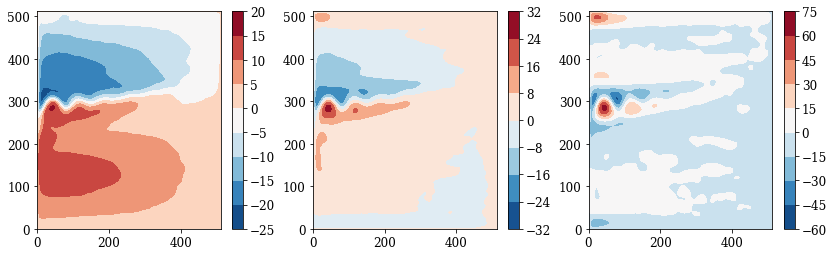

In [5]:
# load data as is, and let subroutine take care of normalisation with time-average
psi_tave = load_grid_data(data_dir, "psi_int.dat", tave=True)
psi_m = grid_to_mesh(psi_tave, 
                     [Function(space, name = "psi_m_%i" % (i + 1)) for i in range(layers)])
    
# test plot
fig = plt.figure(figsize = (14, 4))

for layer in range(layers):
    ax = plt.subplot(1, layers, layer+1)
    cs = ax.contourf(x_vec, y_vec, float(H[layer]) * psi_tave[layer, :, :] * scale * scale / 1e12)
    plt.colorbar(cs)
#del psi_tave

In [6]:
M_m, N_m, P_m, R_m, S_m = uq_c.T_c(psi_m)

computing mean fluxes at
  layer 1...
  layer 2...
  layer 3...
  at interface 1.5...
  at interface 2.5...


In [7]:
# load the various entries in the EP tensor
# TODO: consider being making the loading with filenames more flexible
#       won't need time-averaging if using spatial filtering as the Reynolds decomposition

grid_data = 0.5 * ( load_grid_data(data_dir, "v_v_int.dat", tave=True) 
                   -load_grid_data(data_dir, "u_u_int.dat", tave=True)
                  )
M_a = grid_to_mesh(grid_data, 
                   [Function(space, name = "M_a_%i" % (i + 1)) for i in range(layers)])

grid_data = load_grid_data(data_dir, "u_v_int.dat", tave=True)
N_a = grid_to_mesh(grid_data, 
                   [Function(space, name = "N_a_%i" % (i + 1)) for i in range(layers)])

grid_data = load_grid_data(data_dir, "p_l_int.dat", tave=True)
P_a = grid_to_mesh(grid_data, 
                   [Function(space, name = "P_a_%i" % (i + 1)) for i in range(layers)])

grid_data = load_grid_data(data_dir, "r_int.dat", layers=layers-1, tave=True)
R_a = grid_to_mesh(grid_data, 
                   [Function(space, name = "R_a_%i" % (i + 1)) for i in range(layers-1)])

grid_data = load_grid_data(data_dir, "s_int.dat", layers=layers-1, tave=True)
S_a = grid_to_mesh(grid_data, 
                   [Function(space, name = "S_a_%i" % (i + 1)) for i in range(layers-1)])

In [8]:
M_e = [Function(space, name = "M_e_%i" % (i + 1)) for i in range(layers)]
N_e = [Function(space, name = "N_e_%i" % (i + 1)) for i in range(layers)]
P_e = [Function(space, name = "P_e_%i" % (i + 1)) for i in range(layers)]
for l in range(layers):
    M_e[l].vector()[:] = M_a[l].vector() - M_m[l].vector()
    N_e[l].vector()[:] = N_a[l].vector() - N_m[l].vector()
    P_e[l].vector()[:] = P_a[l].vector() - P_m[l].vector()
R_e = [Function(space, name = "R_e_%i" % (i + 1)) for i in range(layers - 1)]
S_e = [Function(space, name = "S_e_%i" % (i + 1)) for i in range(layers - 1)]
for l in range(layers - 1):
    R_e[l].vector()[:] = R_a[l].vector() - R_m[l].vector()
    S_e[l].vector()[:] = S_a[l].vector() - S_m[l].vector()

In [9]:
# computing PV eddy force function
T_empb = uq_c.T(M = M_e, N = N_e, P = P_e, R = R_e, S = S_e)
uq_empb, vq_empb = uq_c.uq(T_empb)
ffd_empb = uq_c.uq_ffd(uq_empb, vq_empb, name = "ffd_empb")

filling out the EP tensor
computing for the PV flux in
  layer 1
  layer 2
  layer 3
computing for the appropriate eddy force functions
  at layer 1
  at layer 2
  at layer 3


In [10]:
# computing force function associated with Reynolds stresses
T_em = uq_c.T(M = M_e, N = N_e)
uq_em, vq_em = uq_c.uq(T_em)
ffd_em = uq_c.uq_ffd(uq_em, vq_em, name = "ffd_em")

filling out the EP tensor
computing for the PV flux in
  layer 1
  layer 2
  layer 3
computing for the appropriate eddy force functions
  at layer 1
  at layer 2
  at layer 3


In [11]:
# computing force function associated with form stresses
T_eb = uq_c.T(R = R_e, S = S_e)
uq_eb, vq_eb = uq_c.uq(T_eb)
ffd_eb = uq_c.uq_ffd(uq_eb, vq_eb, name = "ffd_eb")

filling out the EP tensor
computing for the PV flux in
  layer 1
  layer 2
  layer 3
computing for the appropriate eddy force functions
  at layer 1
  at layer 2
  at layer 3


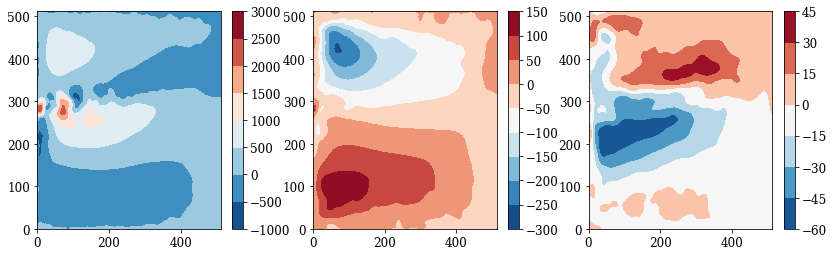

In [12]:
# integrate
fig = plt.figure(figsize = (14, 4))
for layer in range(layers):
    ax = plt.subplot(1, layers, layer+1)
    cs = ax.tricontourf(triang,ffd_empb[layer].compute_vertex_values(),origin='lower')
    plt.colorbar(cs)

In [13]:
fn='empb'# 'em','eb'

if fn =='empb':
    ffd = ffd_empb
    fn_label='q'
elif fn == 'em':
    ffd = ffd_em
    fn_label='\zeta'
else:
    ffd = ffd_eb
    fn_label='b'
        
grad_u = [Function(space, name = "grad_u_%i" % (i + 1)) for i in range(layers)] 
for l in range(layers): 
    L = (grad(ffd_empb[l])[0] - trial) * test * dx
    solve(lhs(L) == rhs(L), grad_u[l])

grad_v = [Function(space, name = "grad_v_%i" % (i + 1)) for i in range(layers)] 
for l in range(layers):
    L = (grad(ffd_empb[l])[1] - trial) * test * dx
    solve(lhs(L) == rhs(L), grad_v[l])

lap_eff = [Function(space, name = "lap_eff_%i" % (i + 1)) for i in range(layers)] 
for l in range(layers):
    L = (div(as_vector([grad_u[l], grad_v[l]])) - trial) * test * dx
    solve(lhs(L) == rhs(L), lap_eff[l])

In [15]:
grad_u_grid=mesh_to_grid(grad_u)
grad_v_grid=mesh_to_grid(grad_v)
#np.savez('../data/training/00/grad_%s_%i'%(fn,ntau),grad_u=grad_u_grid,grad_v=grad_v_grid)

In [13]:
#ffd_empb_grid= mesh_to_grid(ffd_empb)
#np.save('../data/training/00/ffd_%s_%i'%(fn,ntau),ffd_empb_grid)

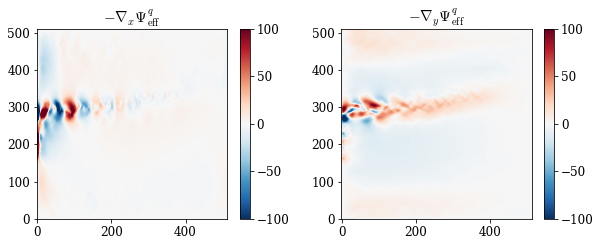

In [16]:
lm=100
fig=plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(-grad_u_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$- \nabla_x  \Psi^%s_{\rm eff}$'%(fn_label),fontsize=15)

plt.subplot(122)
plt.imshow(-grad_v_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$- \nabla_y \Psi^%s_{\rm eff}$'%(fn_label),fontsize=15)

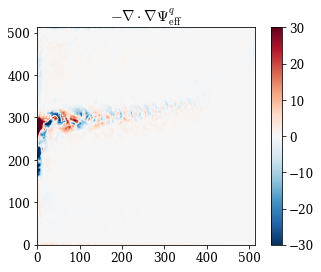

In [17]:
lm=30
plt.imshow(-mesh_to_grid(lap_eff)[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$ -\nabla \cdot  \nabla  \Psi^{%s}_{\rm eff} $'%(fn_label),fontsize=15)

In [18]:
#uvq
fn='empb'#,'em','eb'

if fn =='empb':
    uq_1 = uq_empb
    vq_1 = vq_empb
    fn_label='q'
elif fn == 'em':
    uq_1 = uq_em
    vq_1 = vq_em
    fn_label='\zeta'
else:
    uq_1 = uq_eb
    vq_1 = vq_eb
    fn_label='b'
        
div_uq_o = [Function(space, name = "div_uq_o_%i" % (i + 1)) for i in range(layers)]
for l in range(layers):  
    L = (div(as_vector([uq_1[l], vq_1[l]])) - trial) * test * dx
    solve(lhs(L) == rhs(L), div_uq_o[l])
    
div_uq_grid_o = mesh_to_grid(div_uq_o)

In [19]:
#np.savez('../data/training/00/uvq_%s_%i'%(fn,ntau),uq=mesh_to_grid(uq_1) ,vq=mesh_to_grid(vq_1) )

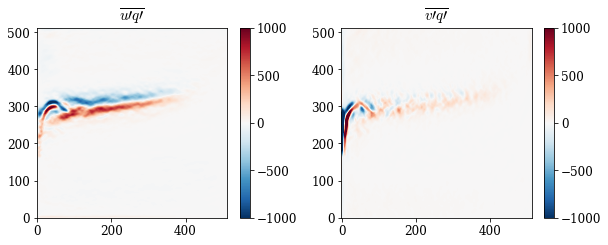

In [20]:
lm=1000
fig=plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(mesh_to_grid(uq_1)[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$\overline{u\prime %s\prime}$ '%(fn_label),fontsize=15)

plt.subplot(122)
plt.imshow(mesh_to_grid(vq_1)[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$\overline{v\prime %s\prime}$ '%(fn_label),fontsize=15)

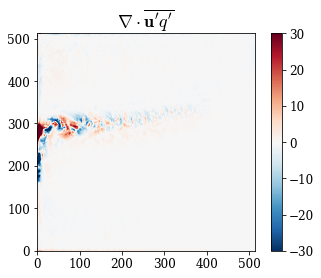

In [21]:
lm=30
plt.imshow(div_uq_grid_o[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$ \nabla \cdot \overline{\mathbf{u}^{\prime} %s^{\prime}} $'%(fn_label),fontsize=18)

In [23]:
#np.save('../data/training/00/div_uq_%s_%i'%(fn,ntau),div_uq_grid_o)